In [305]:
import pydotplus
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.tree import (DecisionTreeClassifier, export_graphviz)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                              ExtraTreesClassifier, AdaBoostClassifier,
                             GradientBoostingClassifier, VotingClassifier)
from sklearn.externals import joblib
from IPython.display import Image

### import data

In [306]:
data = pd.read_csv('../../Data/WeatherOutagesAllJerry.csv')

In [307]:
# clean up data
data = data.dropna(how = 'all')
data = data.fillna(0)
data = data.round(4)

In [308]:
# # of outages apart from equipment outage
natural = data['natural'] = data.Trees + data.Animals + data.Lightning
pd.set_option('display.max_columns', 500)
data.head(5)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,9/13/00,1.0,1.0,0.0,0.0,0.0,12.6667,77.0,64.0,54.0,97.0,74.0,52.0,10.0,10.0,10.0,16.0,7.0,25.0,0.00,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9/14/00,0.0,0.0,0.0,0.0,0.0,12.6167,84.0,71.0,60.0,87.0,66.0,39.0,10.0,10.0,10.0,17.0,12.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9/15/00,1.0,1.0,0.0,0.0,0.0,12.5500,73.0,66.0,59.0,97.0,79.0,53.0,10.0,10.0,10.0,12.0,5.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [309]:
data['Total_outages'].max()

49.0

In [310]:
data['natural'].max()

47.0

In [311]:
data['Equipment'].max()

9.0

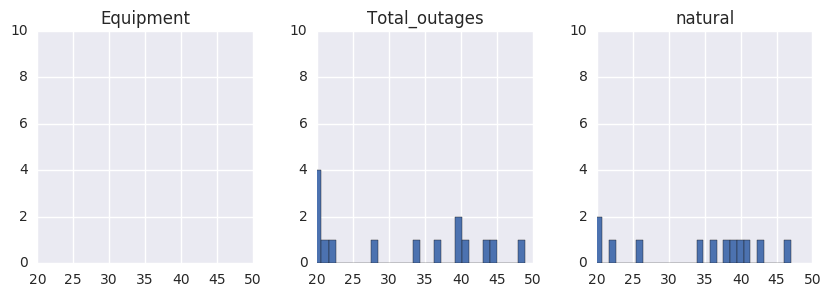

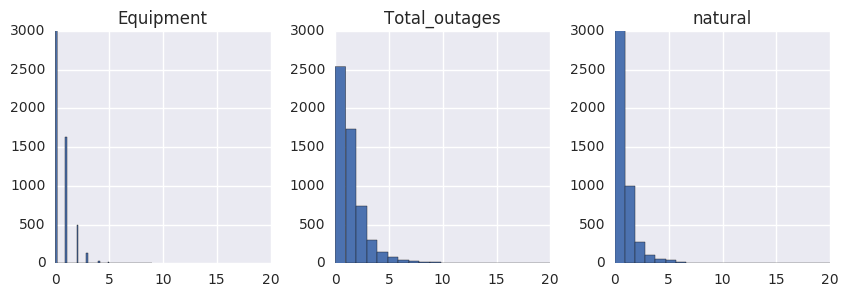

In [312]:
# look at the distribution of power outages

for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((20,50))
        subplot.set_ylim((0,10))
        
for array in data[['Total_outages','natural','Equipment']].hist(figsize=(10,3),layout=(1,3),bins=50):
    for subplot in array:
        subplot.set_xlim((0,20))
        subplot.set_ylim((0,3000))
        
#0-2, 3-8, >9

{'boxes': [<matplotlib.lines.Line2D at 0x11a378b38>],
 'caps': [<matplotlib.lines.Line2D at 0x11515b3c8>,
 'fliers': [<matplotlib.lines.Line2D at 0x116b04dd8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x116b04630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11a378b70>,
  <matplotlib.lines.Line2D at 0x1196e8748>]}

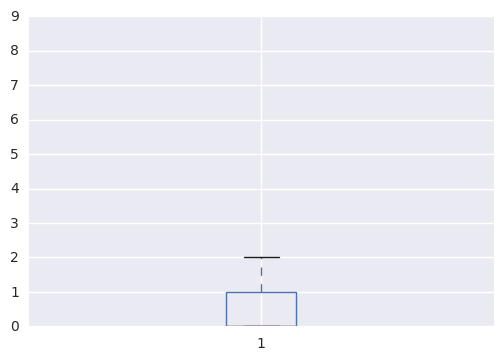

In [313]:
plt.boxplot(data.Equipment)

In [314]:
#data[['Max_temp_F','Avg_Temp_F','Min_temp_F']].plot()
#data[['Max_humidity_percent','Avg_humidity_percent','Min_humidity_percent']].plot()
#data[['Max_visibility_mi']].plot()
#data[['Avg_visibility_mi']].plot()

In [315]:
# convert to classification problem
def f(row):
    """function that categories days with more than 8 outages as extreme, 
                                3-8 outages as bad, and 0-2 as normal"""
    if row['Total_outages'] > 8:
        val = 'extreme'
    elif row['Total_outages'] > 2:
        val = 'bad'
    else:
        val = 'normal'
    return val

data['category'] = data.apply(f, axis=1)

In [316]:
data.head(2)

,Date,Total_outages,Equipment,Trees,Animals,Lightning,Day_length_hr,Max_temp_F,Avg_Temp_F,Min_temp_F,Max_humidity_percent,Avg_humidity_percent,Min_humidity_percent,Max_visibility_mi,Avg_visibility_mi,Min_visibility_mi,Max_windspeed_mph,Avg_windspeed_mph,Max_windgust_mph,Precipitation_in,Events,Event_fog,Event_rain,Event_snow,Event_thunderstorm,Event_Hail,Event_Tornado,natural,category
0,9/11/00,0.0,0.0,0.0,0.0,0.0,12.7833,66.0,58.0,50.0,100.0,89.0,58.0,10.0,6.0,0.0,8.0,2.0,9.0,0.01,Fog,1.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,9/12/00,2.0,1.0,0.0,1.0,0.0,12.7167,75.0,62.0,52.0,100.0,69.0,33.0,10.0,10.0,7.0,8.0,4.0,9.0,0.00,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,normal


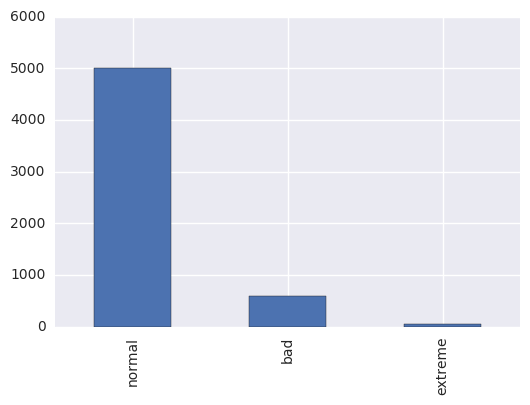

In [317]:
data.category.value_counts().plot(kind='bar')

In [346]:
feature = data[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent',
             'Max_windspeed_mph','Precipitation_in']]
scaler = preprocessing.StandardScaler()
data_std = np.hstack((scaler.fit_transform(feature),np.atleast_2d(pd.factorize(data.category)[0]).T))

In [349]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [350]:
train,test=train_test_split(data_std,test_size=0.2,random_state=567)

In [357]:
np.shape(train[:,0:-1])

(4531, 5)

In [358]:
x_train = train[:,0:-1]
y_train = train[:,-1]

x_test = test[:,0:-1]
y_test = test[:,-1]

In [360]:
x_train.size

22655

In [361]:
y_test.size

1133

### Decision Tree 

In [363]:
clf = dt.fit(x_train,y_train)

y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)

print("Train error for standardized data",mean_squared_error(y_train,y_train_pred))
print("Test error for standardized data",mean_squared_error(y_test,y_test_pred))
print("training score for standardized data",dt.score(x_train,y_train))

tree_dot_std = export_graphviz(clf,out_file = 'tree_all_std.dot')

Train error for standardized data 0.124917236813
Test error for standardized data 0.128861429832
training score for standardized data 0.888324873096


In [364]:
# probability of each event
print(dt.predict_proba(x_train)[0:20], y_test[0:20])

[[ 0.78515625  0.19140625  0.0234375 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.66226913  0.32717678  0.01055409]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.66226913  0.32717678  0.01055409]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.66226913  0.32717678  0.01055409]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.93789717  0.05921433  0.0028885 ]
 [ 0.66226913  0.32717678  0.01055409]
 [ 0.93789717  0.05921433  0.0028885 ]] [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  2.  0.  0.  0.  0.
  0.  2.]


In [366]:
# features importance
list(zip(dt.feature_importances_))

[(0.35530288466855692,),
 (0.2064649666750612,),
 (0.0,),
 (0.35833916407601485,),
 (0.079892984580367005,)]

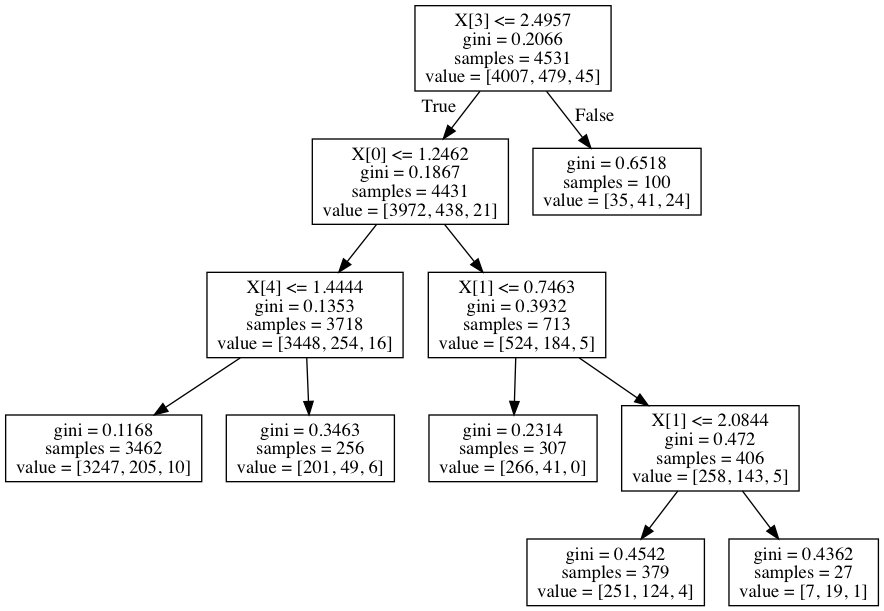

In [367]:
graph = pydotplus.graphviz.graph_from_dot_file('tree_all_std.dot')
Image(graph.create_png())
#plt.savefig('DecisionTree.png')

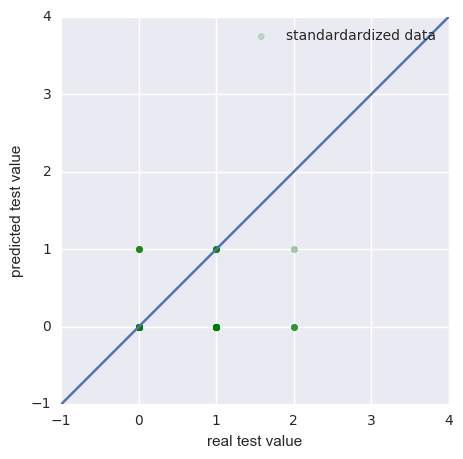

In [368]:
# plot the results
plt.figure(figsize=(5,5))
#plt.scatter(y_test,y_test_pred_nor,alpha=0.2,color='red',label='normalized data')
plt.scatter(y_test,y_test_pred,alpha=0.2,color='green',label='standardardized data')
plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,4])
plt.ylim([-1,4])
plt.legend()

training score using [0, 3] features is 0.678879


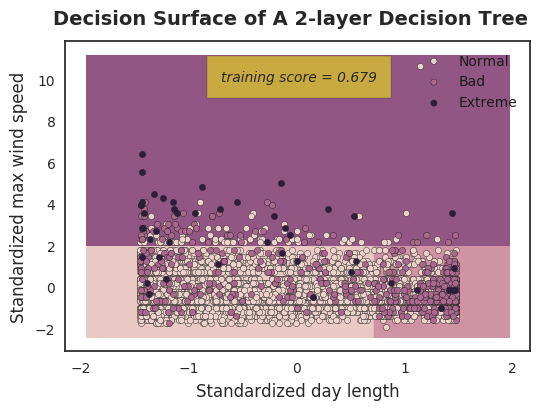

In [371]:
sns.set_style("white")
sns.set_color_codes()
plot_colors = sns.cubehelix_palette(n_colors=3)
cmap = sns.cubehelix_palette(dark=0.4, as_cmap=True)
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses
RANDOM_SEED = 13  # fix the seed on each iteration
n_classes = 3

#for pairidx, pair in enumerate([[0, 3], [0, 4], [3, 4]]):
for pairidx, pair in enumerate([[0, 3]]):
# We only take the two corresponding features
    X = x_train[:,pair]
    y = y_train

    # Train
    clf = DecisionTreeClassifier(min_samples_leaf=5,max_depth=2,class_weight='balanced').fit(X, y)
    print("training score using %s features is %f" % (pair, clf.score(X,y)))
    # Plot the decision boundary
    #plt.subplot(1, 3, pairidx+1)
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap)

    plt.axis("tight")

    # Plot the training points
    for i, color,label_ in zip(range(n_classes), plot_colors, ["Normal",'Bad','Extreme']):
        idx = np.where(y == i)
        plt.scatter(X[idx[0].tolist(), 0], X[idx[0].tolist(), 1], c=color,label=label_,
                    cmap=cmap)

plt.axis("tight")
plt.xlabel("Standardized day length",fontsize=12)
plt.ylabel("Standardized max wind speed",fontsize=12)
plt.suptitle("Decision Surface of A 2-layer Decision Tree",fontsize=14, fontweight='bold')
plt.text(-0.7, 10, 'training score = 0.679', style='italic',
        bbox={'facecolor':'yellow', 'alpha':0.5, 'pad':10})

leg = plt.legend()
frame = leg.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')
for text in leg.get_texts():
    plt.setp(text, color = 'k')
plt.savefig('DecisionBoundary.png')
plt.show()

### Ensemble Tree Methods

### without weights on class

Train error for standardized data using DecisionTree is 0.124917236813
Test error for standardized data using DecisionTree is 0.128861429832
Feature importance using DecisionTree is 
 [(0, 0.35530288466855692), (1, 0.2064649666750612), (2, 0.0), (3, 0.35833916407601485), (4, 0.079892984580367005)] 

Train error for standardized data using RandomForest is 0.104391966453
Test error for standardized data using RandomForest is 0.130626654898
Feature importance using RandomForest is 
 [(0, 0.26804638892182614), (1, 0.21297146234466471), (2, 0.16023507580606275), (3, 0.23541387665341462), (4, 0.12333319627403179)] 

Train error for standardized data using ExtraTrees is 0.139483557714
Test error for standardized data using ExtraTrees is 0.137687555163
Feature importance using ExtraTrees is 
 [(0, 0.26970126411865764), (1, 0.22604873657003166), (2, 0.11445242172534974), (3, 0.27887174928223135), (4, 0.1109258283037296)] 

Train error for standardized data using AdaBoost is 0.112337232399
Test 

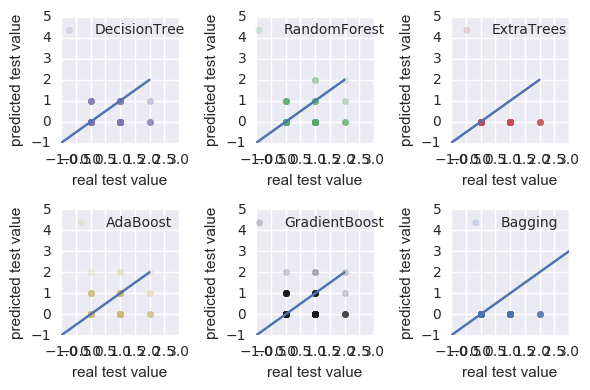

In [270]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_leaf_nodes=6,min_samples_leaf=5, presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1)
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf_std = method.fit(x_train,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,5])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()

### with weights on class

In [267]:
n_estimators = 30 # number of trees used, default=10 for rf, et, 50 for ab, 100 for gb
#n_jobs=-1, the number of jobs is set to the number of cores

dt = DecisionTreeClassifier(max_leaf_nodes=6,min_samples_leaf=5, 
                            class_weight='balanced', presort=True)
rf = RandomForestClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                            class_weight='balanced')
et = ExtraTreesClassifier(n_estimators=n_estimators,min_samples_leaf=5,n_jobs=-1,
                          class_weight='balanced')
ab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),learning_rate=0.1)
bg = BaggingClassifier(max_samples=3,n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5)

Train error for standardized data using DecisionTree is 0.124917236813
Test error for standardized data using DecisionTree is 0.128861429832
Feature importance using DecisionTree is 
 [(0, 0.35530288466855692), (1, 0.2064649666750612), (2, 0.0), (3, 0.35833916407601485), (4, 0.079892984580367005)] 

Train error for standardized data using RandomForest is 0.10152284264
Test error for standardized data using RandomForest is 0.132391879965
Feature importance using RandomForest is 
 [(0, 0.27779637215360714), (1, 0.2094131271091621), (2, 0.15450373920777333), (3, 0.23575617562303169), (4, 0.12253058590642567)] 

Train error for standardized data using ExtraTrees is 0.145442507173
Test error for standardized data using ExtraTrees is 0.137687555163
Feature importance using ExtraTrees is 
 [(0, 0.25056005436922557), (1, 0.22860274520596893), (2, 0.11062509859095053), (3, 0.27080965879202173), (4, 0.10606910970849986)] 

Train error for standardized data using AdaBoost is 0.112337232399
Test e

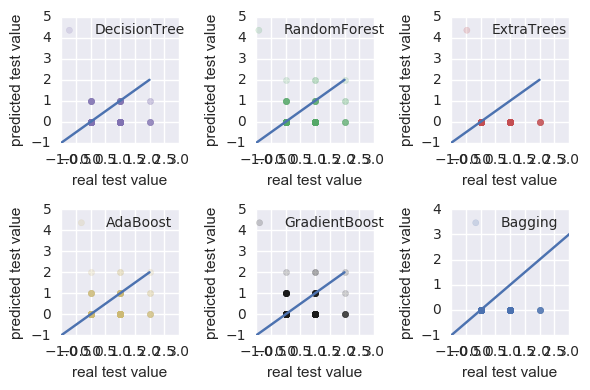

In [271]:
plot_idx = 1
for method, color_, label_ in [(dt,'m','DecisionTree'),(rf,'g','RandomForest'), (et,'r','ExtraTrees'),
                               (ab,'y','AdaBoost'),(gb,'k','GradientBoost')]:
    clf = method.fit(x_train_std,y_train)

    y_train_pred_std = method.predict(x_train_std)
    y_test_pred_std = method.predict(x_test_std)

    print("Train error for standardized data using %s is" % (label_),mean_squared_error(y_train,y_train_pred_std))
    print("Test error for standardized data using %s is" % (label_),mean_squared_error(y_test,y_test_pred_std))
    print("Feature importance using %s is" % (label_),'\n',list(zip(x_train_std, method.feature_importances_)),'\n')
    plt.subplot(2, 3, plot_idx)
    plt.scatter(y_test,y_test_pred_std,alpha=0.2,color=color_,label=label_)
    plt.plot(np.arange(-1,3),np.arange(-1,3))
    plt.xlabel('real test value')
    plt.ylabel('predicted test value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
    plt.xlim([-1,3])
    plt.ylim([-1,5])
    plt.tight_layout()
    plot_idx += 1
    
clf_std = bg.fit(x_train_std,y_train)
y_train_pred_std = bg.predict(x_train_std)
y_test_pred_std = bg.predict(x_test_std)
print("Train error for standardized data using %s is" % 'Bagging',mean_squared_error(y_train,y_train_pred_std))
print("Test error for standardized data using %s is" % 'Bagging',mean_squared_error(y_test,y_test_pred_std))

plt.subplot(2, 3, 6)
plt.scatter(y_test,y_test_pred_std,alpha=0.2,color='b',label='Bagging')    

plt.xlabel('real test value')
plt.ylabel('predicted test value')
plt.plot(np.arange(-5,30),np.arange(-5,30))
plt.xlim([-1,3])
plt.ylim([-1,4])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()

In [273]:
dt.fit(x_train_std,y_train)
rf.fit(x_train_std,y_train)
et.fit(x_train_std,y_train)
ab.fit(x_train_std,y_train)
bg.fit(x_train_std,y_train)
gb.fit(x_train_std,y_train)

#joblib.dump(dt, 'dt.pkl')
#joblib.dump(rf, 'rf.pkl')
#joblib.dump(et, 'et.pkl')
#joblib.dump(ab, 'ab.pkl')
#joblib.dump(bg, 'bg.pkl')
#joblib.dump(gb, 'gb.pkl')

['gb.pkl']

In [285]:
weather = pd.DataFrame()
weatherData = weather.append({"Day_length_hr": 11, 
                "Avg_Temp_F": 38,
                "Avg_humidity_percent": 85,
                "Max_windspeed_mph": 16,
                "Avg_windspeed_mph": 7,
                "Max_windgust_mph": 20,
                "Precipitation_in": 0.33},
                ignore_index=True)
weatherData

,Avg_Temp_F,Avg_humidity_percent,Avg_windspeed_mph,Day_length_hr,Max_windgust_mph,Max_windspeed_mph,Precipitation_in
0,38.0,85.0,7.0,11.0,20.0,16.0,0.33


In [286]:
weather = pd.DataFrame(preprocessing.scale(weatherData[['Day_length_hr','Avg_Temp_F','Avg_humidity_percent','Max_windspeed_mph','Precipitation_in']]))
weather = weather.fillna(0)
weather

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0


In [287]:
print(dt.predict(weather))

[0]


### count correctness for difference classes

In [125]:
df = pd.DataFrame()
for method, label_ in [(dt,'DecisionTree'),(rf,'RandomForest'), (et,'ExtraTrees'),
                               (ab,'AdaBoost'),(gb,'GradientBoost'),(bg,'Bagging')]:
    clf = method.fit(x_train_std,y_train)
    y_pred = method.predict(x_test_std)
    y_test = pd.DataFrame(y_test)
    #initialize counters 
    overall_correctness = 0
    under_predict_normal = 0
    right_predict_normal = 0
    over_predict_normal = 0
    under_predict_bad = 0
    right_predict_bad = 0
    over_predict_bad = 0
    under_predict_extreme = 0
    right_predict_extreme = 0
    over_predict_extreme = 0
    
    for index, row in y_test.iterrows():
        if y_pred[index] == row.values: # predict correctly
            overall_correctness += 1
            if row.values == 0:
                right_predict_normal += 1
            elif row.values == 1:
                right_predict_bad += 1
            else:
                right_predict_extreme += 1
        elif row.values == 0:
            over_predict_normal += 1
        elif row.values == 1:
            if y_pred[index] == 0:
                under_predict_bad += 1
            else:
                over_predict_bad += 1
        else:
            under_predict_extreme += 1
    
    df = df.append({"Method": label_, "Overall_Correctness": overall_correctness/index,
                    "right_predict_normal": right_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "right_predict_bad": right_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "right_predict_extreme": right_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "under_predict_normal": under_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "under_predict_bad": under_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "under_predict_extreme": under_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme),
                    "over_predict_normal": over_predict_normal/(right_predict_normal
                                            + under_predict_normal + over_predict_normal),
                    "over_predict_bad": over_predict_bad/(right_predict_bad
                                            + under_predict_bad + over_predict_bad),
                    "over_predict_extreme": over_predict_extreme/(right_predict_extreme
                                            + under_predict_extreme + over_predict_extreme)},
                  ignore_index=True)
df.to_csv('TreeMethodsResults_NoGust.csv')
df
                
        

,Method,Overall_Correctness,over_predict_bad,over_predict_extreme,over_predict_normal,right_predict_bad,right_predict_extreme,right_predict_normal,under_predict_bad,under_predict_extreme,under_predict_normal
0,DecisionTree,0.631625,0.225000,0.0,0.344622,0.441667,0.444444,0.655378,0.333333,0.555556,0.0
1,RandomForest,0.828622,0.041667,0.0,0.110558,0.358333,0.222222,0.889442,0.600000,0.777778,0.0
2,ExtraTrees,0.763251,0.116667,0.0,0.202191,0.491667,0.444444,0.797809,0.391667,0.555556,0.0
3,AdaBoost,0.893110,0.016667,0.0,0.008964,0.125000,0.111111,0.991036,0.858333,0.888889,0.0
4,GradientBoost,0.883392,0.016667,0.0,0.019920,0.125000,0.111111,0.980080,0.858333,0.888889,0.0
5,Bagging,0.886926,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.0


In [135]:
df.iloc[:,0].tolist()

['DecisionTree',
 'RandomForest',
 'ExtraTrees',
 'AdaBoost',
 'GradientBoost',
 'Bagging']

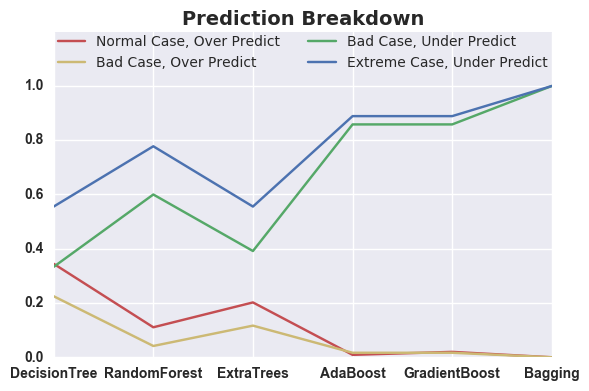

In [261]:
sns.set_style("darkgrid")
plt.plot(x,df.over_predict_normal,label='Normal Case, Over Predict',color='r')
plt.plot(x,df.over_predict_bad,label='Bad Case, Over Predict',color='y')

plt.plot(x,df.under_predict_bad,label='Bad Case, Under Predict',color='g')
plt.plot(x,df.under_predict_extreme,label='Extreme Case, Under Predict',color='b')

x = range(6)
my_xticks = df.iloc[:,0].tolist()
plt.xticks(x, my_xticks,fontweight='bold')
plt.yticks(fontweight='bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03),ncol=2, fancybox=True, shadow=True)
plt.ylim(0,1.2)
plt.title("Prediction Breakdown",fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('PredictionBreakdown.png')

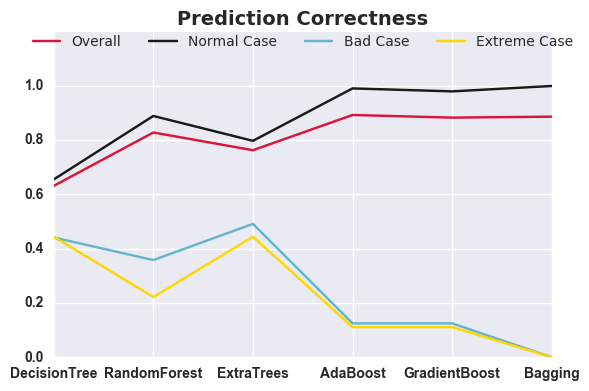

In [256]:
sns.set_style("darkgrid")
plt.plot(x,df.iloc[:,1],label='Overall',color='crimson')
plt.plot(x,df.right_predict_normal,label='Normal Case',color='k')
plt.plot(x,df.right_predict_bad,label='Bad Case',color='c')
plt.plot(x,df.right_predict_extreme,label='Extreme Case',color='gold')
x = range(6)
my_xticks = df.iloc[:,0].tolist()
plt.xticks(x, my_xticks,fontweight='bold')
plt.yticks(fontweight='bold')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03),ncol=4, fancybox=True, shadow=True)
plt.ylim(0,1.2)
plt.title("Prediction Correctness",fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('PredictionCorrectness.png')